## Analyzing trajectory set 2

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import movingpandas as mpd
import shapely as shp
import hvplot.pandas 
import matplotlib.pyplot as plt
from utils import *
from geopandas import GeoDataFrame, read_file
from shapely.geometry import Point, LineString, Polygon
from datetime import datetime, timedelta
from holoviews import opts, dim
from os.path import exists
from urllib.request import urlretrieve
import seaborn as sns
from hausdorff import hausdorff_distance
from scipy.spatial.distance import directed_hausdorff
from sklearn.cluster import DBSCAN
import hdbscan
from kneed import *
import warnings
from geopy.distance import great_circle
from shapely.geometry import Point, LineString, Polygon, MultiPoint
from dtw import *
from haversine import *
from sklearn.neighbors import NearestNeighbors
import panel as pn
from sdtw import SoftDTW
warnings.filterwarnings('ignore')

plot_defaults = {'linewidth':5, 'capstyle':'round', 'figsize':(12,6), 'legend':True}
opts.defaults(opts.Overlay(active_tools=['wheel_zoom'], frame_width=800, frame_height=500))
hvplot_defaults = {'tiles':None, 'cmap':'Viridis', 'colorbar':True}
# os.environ['GDAL_DATA'] = r'/slurm/home/yrd/luolab/zhaoliang/.conda/envs/py310/Library\share\gdal'

from sklearn import metrics
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
from cartopy.io.img_tiles import OSM
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
df = pd.read_csv('intersection_2021_72.csv')
# df = df[df["LLI NO"].str.contains("1091853") == False]

In [3]:
# define the boundary
df_traj = df[df['Lng'] > -5.8]
df_traj = df_traj[df_traj['Lng'] < 32.3]
df_traj = df_traj[df_traj['Lat'] < 44.6]
df_traj = df_traj[df_traj['Lat'] > 1.135]

# Gibraltar Strait
area_of_gs = Polygon([(-6, 35.8), (-5,  35.8), (-5, 36.2), (-6, 36.2)]) 

# Suez Canal
area_of_sc = Polygon([(32, 31.3), (32.6,  31.3), (32.6, 31.7), (32, 31.7)]) # Suez canal

gdf = gpd.GeoDataFrame(df_traj, geometry=gpd.points_from_xy(df_traj.Lng, df_traj.Lat))

traj_collection = mpd.TrajectoryCollection(gdf, 'LLI NO', t='t', crs="EPSG:4326 WGS84")
traj = find_intersection(traj_collection, area_of_gs, area_of_sc)

print(f"Found {len(traj)} trajectories between Gibraltar Strait and Suez Canal")
df_traje = traj.to_traj_gdf()
df_traje = df_traje.drop('geometry', axis=1)
df_traje = df_traje[df_traje['length']<110]


# from india to suez canal
traj_list_sc2gs = [traje for traje in traj if traje.get_start_location().intersects(area_of_sc)]
traj_list_gs2sc = [traje for traje in traj if traje.get_start_location().intersects(area_of_gs)]

print(f"Found {len(traj_list_sc2gs)} trajectories from Suez canal to Gibraltar Strait")
print(f"Found {len(traj_list_gs2sc)} trajectories from Gibraltar Strait to Canal")

traj_collection_sc2gs = mpd.TrajectoryCollection(traj_list_sc2gs)
traj_collection_gs2sc = mpd.TrajectoryCollection(traj_list_gs2sc)


# traj_collection_sc2gs_DP = DPcompression(traj_collection_sc2gs, 0.2)
# traj_collection_gs2sc_DP = DPcompression(traj_collection_gs2sc, 0.2)

df_traje_all = traj.to_traj_gdf()


Found 473 trajectories
Found 473 trajectories between Gibraltar Strait and Suez Canal
Found 253 trajectories from Suez canal to Gibraltar Strait
Found 220 trajectories from Gibraltar Strait to Canal


In [7]:
# points = traj.to_point_gdf().geometry
# xs = [point.x for point in points]
# ys = [point.y for point in points]
# CPs = pd.DataFrame(xs, ys)
# CPs.to_csv('points_set_2.csv')

<Axes: xlabel='company'>

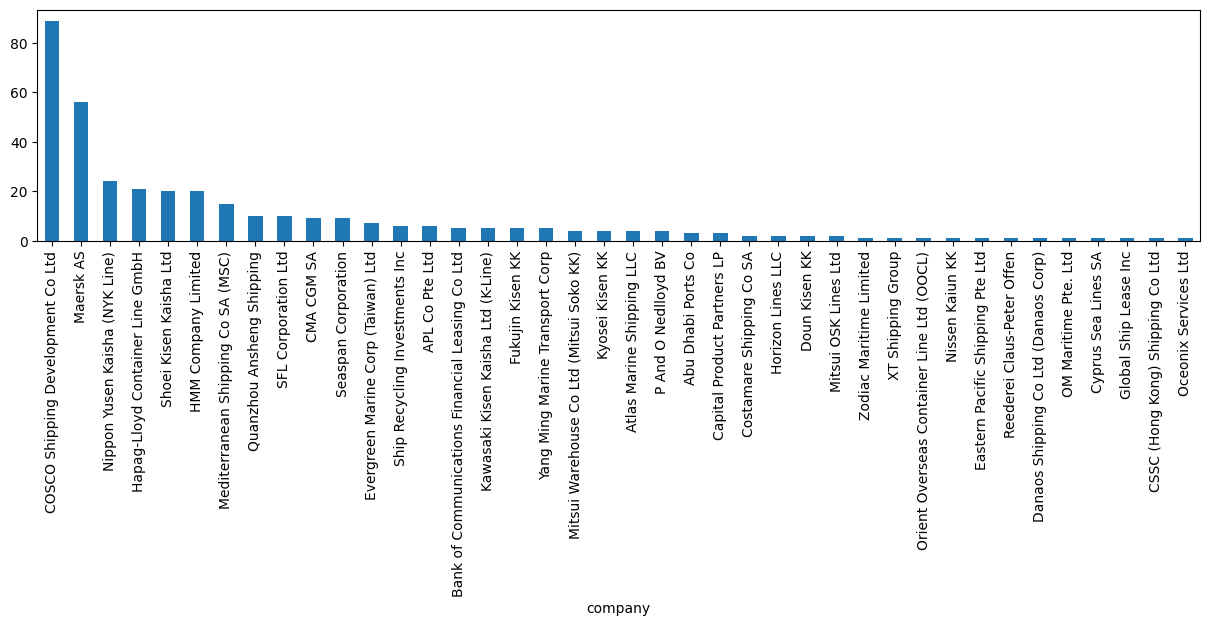

In [4]:
df_traje_all['IMO'] = np.nan

df1=pd.read_csv('container.csv')
df1['LLINO'] = df1['LLINO'].astype(str)
LLIstring = df1['LLINO']

IMOstring = df1['IMO']

for i in range(0, LLIstring.shape[0]):
    id = df_traje_all[df_traje_all['LLI NO'].str.contains(LLIstring[i], na=False)].index
    if (id.empty):
        continue
    else:
        for j in range(0, id.shape[0]):
            # df_traj[id[j], 'IMO'] = IMOstring[j]
            df_traje_all.loc[id[j], 'IMO'] = IMOstring[i]

df_traje_all['flag'] = np.nan
df_traje_all['company'] = np.nan
df_traje_all['IMO'] = df_traje_all['IMO'].astype(str)

df_IMO_company = pd.read_csv('info.csv')

IMOString = df_IMO_company['IMO'].astype(str)

for i in range(0, IMOString.shape[0]):
    id = df_traje_all[df_traje_all['IMO'].str.contains(IMOString[i], na=False)].index
    if (id.empty):
        continue
    else:
        for j in range(0, id.shape[0]):
            # df_traj[id[j], 'IMO'] = IMOstring[j]
            df_traje_all.loc[id[j], 'flag'] = df_IMO_company.loc[i, 'Flag']
            df_traje_all.loc[id[j], 'company'] = df_IMO_company.loc[i, 'Company']


df_traje_all = df_traje_all.drop(df_traje_all[df_traje_all['company'] == 'no record'].index)
df_traje_all['company'].value_counts().plot(kind='bar', figsize=(15,3))

In [5]:
df_traje_all['company'].value_counts()

company
COSCO Shipping Development Co Ltd                  89
Maersk AS                                          56
Nippon Yusen Kaisha (NYK Line)                     24
Hapag-Lloyd Container Line GmbH                    21
Shoei Kisen Kaisha Ltd                             20
HMM Company Limited                                20
Mediterranean Shipping Co SA (MSC)                 15
Quanzhou Ansheng Shipping                          10
SFL Corporation Ltd                                10
CMA CGM SA                                          9
Seaspan Corporation                                 9
Evergreen Marine Corp (Taiwan) Ltd                  7
Ship Recycling Investments Inc                      6
APL Co Pte Ltd                                      6
Bank of Communications Financial Leasing Co Ltd     5
Kawasaki Kisen Kaisha Ltd (K-Line)                  5
Fukujin Kisen KK                                    5
Yang Ming Marine Transport Corp                     5
Mitsui Warehouse Co 

In [4]:
traj_list_sc2gs = [traje for traje in traj if traje.get_start_location().intersects(area_of_sc)]
traj_list_gs2sc = [traje for traje in traj if traje.get_start_location().intersects(area_of_gs)]
traj_collection_sc2gs = mpd.TrajectoryCollection(traj_list_sc2gs)
traj_collection_gs2sc = mpd.TrajectoryCollection(traj_list_gs2sc)
print(f"Found {len(traj_list_sc2gs)} trajectories from Colombo to Suez canal")
print(f"Found {len(traj_list_gs2sc)} trajectories from suez canal to Colombo")

df_traje = traj_collection_sc2gs.to_traj_gdf()
df_traje_reverse = traj_collection_gs2sc.to_traj_gdf()

Found 253 trajectories from Colombo to Suez canal
Found 220 trajectories from suez canal to Colombo


In [7]:
df_traje['IMO'] = np.nan

df1=pd.read_csv('container.csv')
df1['LLINO'] = df1['LLINO'].astype(str)
LLIstring = df1['LLINO']

IMOstring = df1['IMO']

for i in range(0, LLIstring.shape[0]):
    id = df_traje[df_traje['LLI NO'].str.contains(LLIstring[i], na=False)].index
    if (id.empty):
        continue
    else:
        for j in range(0, id.shape[0]):
            # df_traj[id[j], 'IMO'] = IMOstring[j]
            df_traje.loc[id[j], 'IMO'] = IMOstring[i]

df_traje['flag'] = np.nan
df_traje['company'] = np.nan
df_traje['IMO'] = df_traje['IMO'].astype(str)

df_IMO_company = pd.read_csv('info.csv')

IMOString = df_IMO_company['IMO'].astype(str)

for i in range(0, IMOString.shape[0]):
    id = df_traje[df_traje['IMO'].str.contains(IMOString[i], na=False)].index
    if (id.empty):
        continue
    else:
        for j in range(0, id.shape[0]):
            # df_traj[id[j], 'IMO'] = IMOstring[j]
            df_traje.loc[id[j], 'flag'] = df_IMO_company.loc[i, 'Flag']
            df_traje.loc[id[j], 'company'] = df_IMO_company.loc[i, 'Company']

In [10]:
df_flag = df_traje
df_flag = df_flag.drop(df_flag[df_flag['company'] == 'no record'].index)

df_flag_1 = df_flag[df_flag['company'] == 'COSCO Shipping Development Co Ltd']
df_flag_2 = df_flag[df_flag['company'] == 'Maersk AS']

df_flag_3 = df_flag[df_flag['company'] == 'Nippon Yusen Kaisha (NYK Line)']
df_flag_4 = df_flag[df_flag['company'] == 'Hapag-Lloyd Container Line GmbH']

df_flag_5 = df_flag[df_flag['company'] == 'Mediterranean Shipping Co SA (MSC)']
df_flag_6 = df_flag[df_flag['company'] == 'Quanzhou Ansheng Shipping']

# traj_flag_1 = mpd.Trajectory(df_flag_1, 'LLI NO')
df_flag_1.hvplot(title='COSCO', geo=True, hover_cols=['weight'], line_width=1, color='b', tiles='EsriNatGeo', frame_height=800, frame_width=500) +\
df_flag_2.hvplot(title='Maersk AS', geo=True, hover_cols=['weight'], line_width=1, color='b', tiles='EsriNatGeo', frame_height=800, frame_width=500)

:Layout
   .Overlay.I  :Overlay
      .WMTS.I :WMTS   [Longitude,Latitude]
      .Path.I :Path   [Longitude,Latitude]
   .Overlay.II :Overlay
      .WMTS.I :WMTS   [Longitude,Latitude]
      .Path.I :Path   [Longitude,Latitude]

In [10]:
df_flag_3.hvplot(title='Nippon Yusen Kaisha (NYK Line)', geo=True, hover_cols=['weight'], line_width=1, color='b', tiles='EsriNatGeo', frame_height=800, frame_width=500) +\
df_flag_4.hvplot(title='Hapag-Lloyd Container Line GmbH', geo=True, hover_cols=['weight'], line_width=1, color='b', tiles='EsriNatGeo', frame_height=800, frame_width=500)

:Layout
   .Overlay.I  :Overlay
      .WMTS.I :WMTS   [Longitude,Latitude]
      .Path.I :Path   [Longitude,Latitude]
   .Overlay.II :Overlay
      .WMTS.I :WMTS   [Longitude,Latitude]
      .Path.I :Path   [Longitude,Latitude]

In [12]:
df_flag_5.hvplot(title='Mediterranean Shipping Co SA (MSC)', geo=True, hover_cols=['weight'], line_width=1, color='b', tiles='EsriNatGeo', frame_height=800, frame_width=500) +\
df_flag_6.hvplot(title='Quanzhou Ansheng Shipping', geo=True, hover_cols=['weight'], line_width=1, color='b', tiles='EsriNatGeo', frame_height=800, frame_width=500)

:Layout
   .Overlay.I  :Overlay
      .WMTS.I :WMTS   [Longitude,Latitude]
      .Path.I :Path   [Longitude,Latitude]
   .Overlay.II :Overlay
      .WMTS.I :WMTS   [Longitude,Latitude]
      .Path.I :Path   [Longitude,Latitude]

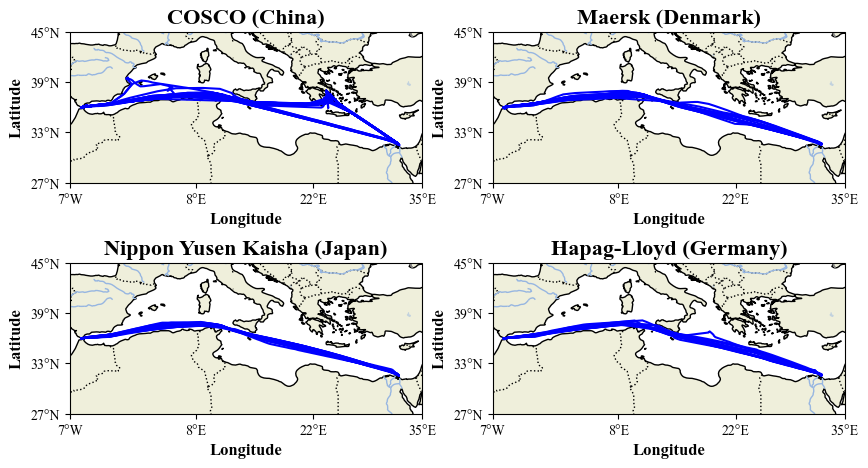

In [11]:
fig = plt.figure(figsize=(10,5.5))
ax = fig.add_subplot(2, 2, 1, projection=ccrs.PlateCarree())
ax = df_flag_1.plot(ax = ax, color="blue")
ax.set_extent([-7, 35, 27, 45], crs=ccrs.PlateCarree())
# ax.stock_img()
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
SOURCE = 'Natural Earth'
LICENSE = 'public domain'
# ax.add_image(imagery)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(states_provinces, edgecolor='gray')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)


fontlabel = {'family': 'times new roman',
        'color':  'black',
        'weight': 'bold',
        'size': 12,
        }
fonttitle = {'family': 'times new roman',
        'color':  'black',
        'weight': 'bold',
        'size': 16,
        }

ax.set_xticks([-7, 8, 22, 35], crs=ccrs.PlateCarree())
ax.set_yticks([27, 33, 39, 45], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
x1_label = ax.get_xticklabels() 
[x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
y1_label = ax.get_yticklabels() 
[y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label]
plt.title('COSCO (China)', fontdict=fonttitle)
plt.xlabel('Longitude', fontdict=fontlabel)
plt.ylabel('Latitude', fontdict=fontlabel)


ax = fig.add_subplot(2, 2, 2, projection=ccrs.PlateCarree())
ax = df_flag_2.plot(ax = ax, color="blue")
ax.set_extent([-7, 35, 27, 45], crs=ccrs.PlateCarree())
# ax.stock_img()
# states_provinces = cfeature.NaturalEarthFeature(
#         category='cultural',
#         name='admin_1_states_provinces_lines',
#         scale='50m',
#         facecolor='none')
SOURCE = 'Natural Earth'
LICENSE = 'public domain'
# ax.add_image(imagery)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(states_provinces, edgecolor='gray')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

ax.set_xticks([-7, 8, 22, 35], crs=ccrs.PlateCarree())
ax.set_yticks([27, 33, 39, 45], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
x1_label = ax.get_xticklabels() 
[x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
y1_label = ax.get_yticklabels() 
[y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label]


plt.title('Maersk (Denmark)', fontdict=fonttitle)
plt.xlabel('Longitude', fontdict=fontlabel)
plt.ylabel('Latitude', fontdict=fontlabel)


ax = fig.add_subplot(2, 2, 3, projection=ccrs.PlateCarree())
ax = df_flag_3.plot(ax = ax, color="blue")
ax.set_extent([-7, 35, 27, 45], crs=ccrs.PlateCarree())
# ax.stock_img()
# states_provinces = cfeature.NaturalEarthFeature(
#         category='cultural',
#         name='admin_1_states_provinces_lines',
#         scale='50m',
#         facecolor='none')
SOURCE = 'Natural Earth'
LICENSE = 'public domain'
# ax.add_image(imagery)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(states_provinces, edgecolor='gray')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

ax.set_xticks([-7, 8, 22, 35], crs=ccrs.PlateCarree())
ax.set_yticks([27, 33, 39, 45], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
x1_label = ax.get_xticklabels() 
[x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
y1_label = ax.get_yticklabels() 
[y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label]


plt.title('Nippon Yusen Kaisha (Japan)', fontdict=fonttitle)
plt.xlabel('Longitude', fontdict=fontlabel)
plt.ylabel('Latitude', fontdict=fontlabel)


ax = fig.add_subplot(2, 2, 4, projection=ccrs.PlateCarree())
ax = df_flag_4.plot(ax = ax, color="blue")
ax.set_extent([-7, 35, 27, 45], crs=ccrs.PlateCarree())
# ax.stock_img()
# states_provinces = cfeature.NaturalEarthFeature(
#         category='cultural',
#         name='admin_1_states_provinces_lines',
#         scale='50m',
#         facecolor='none')
SOURCE = 'Natural Earth'
LICENSE = 'public domain'
# ax.add_image(imagery)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(states_provinces, edgecolor='gray')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

ax.set_xticks([-7, 8, 22, 35], crs=ccrs.PlateCarree())
ax.set_yticks([27, 33, 39, 45], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
x1_label = ax.get_xticklabels() 
[x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
y1_label = ax.get_yticklabels() 
[y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label]


plt.title('Hapag-Lloyd (Germany)', fontdict=fonttitle)
plt.xlabel('Longitude', fontdict=fontlabel)
plt.ylabel('Latitude', fontdict=fontlabel)

# fig.savefig('company sc2gs.png', dpi=600)
plt.show()

In [13]:
df_traje_reverse['IMO'] = np.nan

df1=pd.read_csv('container.csv')
df1['LLINO'] = df1['LLINO'].astype(str)
LLIstring = df1['LLINO']

IMOstring = df1['IMO']

for i in range(0, LLIstring.shape[0]):
    id = df_traje_reverse[df_traje_reverse['LLI NO'].str.contains(LLIstring[i], na=False)].index
    if (id.empty):
        continue
    else:
        for j in range(0, id.shape[0]):
            # df_traj[id[j], 'IMO'] = IMOstring[j]
            df_traje_reverse.loc[id[j], 'IMO'] = IMOstring[i]

df_traje_reverse['flag'] = np.nan
df_traje_reverse['company'] = np.nan
df_traje_reverse['IMO'] = df_traje_reverse['IMO'].astype(str)

df_IMO_company = pd.read_csv('info.csv')

IMOString = df_IMO_company['IMO'].astype(str)

for i in range(0, IMOString.shape[0]):
    id = df_traje_reverse[df_traje_reverse['IMO'].str.contains(IMOString[i], na=False)].index
    if (id.empty):
        continue
    else:
        for j in range(0, id.shape[0]):
            # df_traj[id[j], 'IMO'] = IMOstring[j]
            df_traje_reverse.loc[id[j], 'flag'] = df_IMO_company.loc[i, 'Flag']
            df_traje_reverse.loc[id[j], 'company'] = df_IMO_company.loc[i, 'Company']

:Layout
   .Overlay.I  :Overlay
      .WMTS.I :WMTS   [Longitude,Latitude]
      .Path.I :Path   [Longitude,Latitude]
   .Overlay.II :Overlay
      .WMTS.I :WMTS   [Longitude,Latitude]
      .Path.I :Path   [Longitude,Latitude]

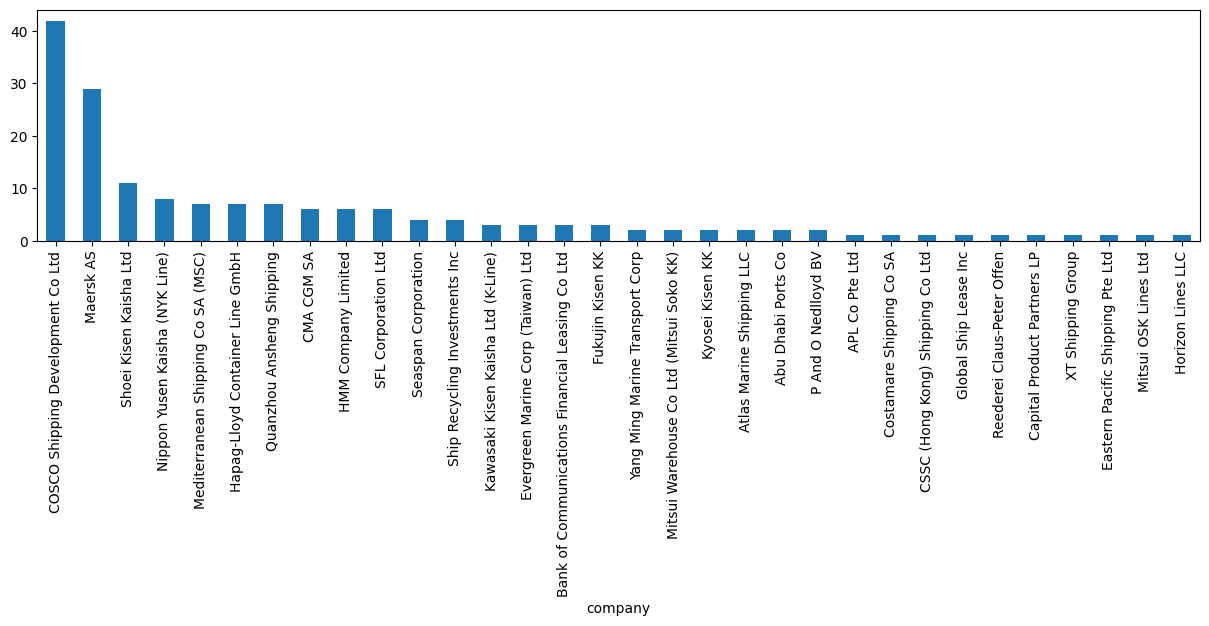

In [15]:
df_flag = df_traje_reverse
df_flag = df_flag.drop(df_flag[df_flag['company'] == 'no record'].index)
df_flag['company'].value_counts().plot(kind='bar', figsize=(15,3))
df_flag_1 = df_flag[df_flag['company'] == 'COSCO Shipping Development Co Ltd']
df_flag_2 = df_flag[df_flag['company'] == 'Maersk AS']

df_flag_3 = df_flag[df_flag['company'] == 'Nippon Yusen Kaisha (NYK Line)']
df_flag_4 = df_flag[df_flag['company'] == 'Hapag-Lloyd Container Line GmbH']

df_flag_5 = df_flag[df_flag['company'] == 'Mediterranean Shipping Co SA (MSC)']
df_flag_6 = df_flag[df_flag['company'] == 'Quanzhou Ansheng Shipping']
# traj_flag_1 = mpd.Trajectory(df_flag_1, 'LLI NO')
# traj_flag_1 = mpd.Trajectory(df_flag_1, 'LLI NO')
df_flag_1.hvplot(title='COSCO', geo=True, hover_cols=['weight'], line_width=1, color='r', tiles='EsriNatGeo', frame_height=800, frame_width=500) +\
df_flag_2.hvplot(title='Maersk AS', geo=True, hover_cols=['weight'], line_width=1, color='r', tiles='EsriNatGeo', frame_height=800, frame_width=500)

In [31]:
df_flag_3.hvplot(title='Nippon Yusen Kaisha (NYK Line)', geo=True, hover_cols=['weight'], line_width=1, color='r', tiles='EsriNatGeo', frame_height=800, frame_width=500) +\
df_flag_4.hvplot(title='Hapag-Lloyd Container Line GmbH', geo=True, hover_cols=['weight'], line_width=1, color='r', tiles='EsriNatGeo', frame_height=800, frame_width=500)

:Layout
   .Overlay.I  :Overlay
      .WMTS.I :WMTS   [Longitude,Latitude]
      .Path.I :Path   [Longitude,Latitude]
   .Overlay.II :Overlay
      .WMTS.I :WMTS   [Longitude,Latitude]
      .Path.I :Path   [Longitude,Latitude]

In [16]:
df_flag_5.hvplot(title='Mediterranean Shipping Co SA (MSC)', geo=True, hover_cols=['weight'], line_width=1, color='r', tiles='EsriNatGeo', frame_height=800, frame_width=500) +\
df_flag_6.hvplot(title='Quanzhou Ansheng Shipping', geo=True, hover_cols=['weight'], line_width=1, color='r', tiles='EsriNatGeo', frame_height=800, frame_width=500)

:Layout
   .Overlay.I  :Overlay
      .WMTS.I :WMTS   [Longitude,Latitude]
      .Path.I :Path   [Longitude,Latitude]
   .Overlay.II :Overlay
      .WMTS.I :WMTS   [Longitude,Latitude]
      .Path.I :Path   [Longitude,Latitude]

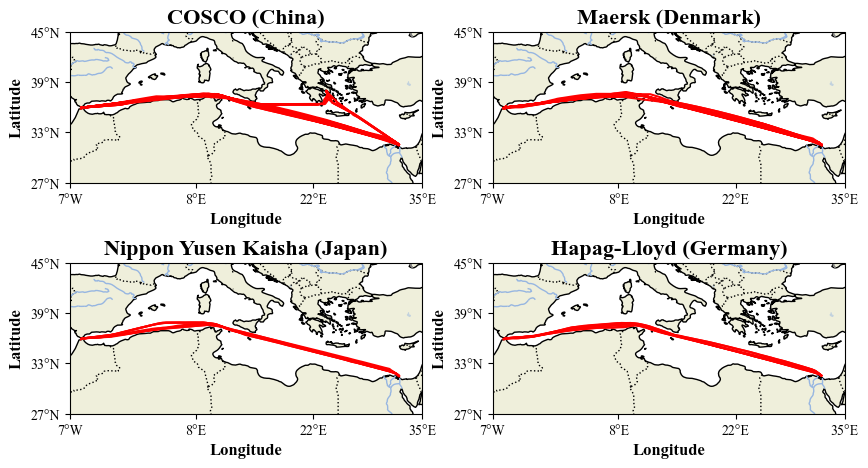

In [14]:
fig = plt.figure(figsize=(10,5.5))
ax = fig.add_subplot(2, 2, 1, projection=ccrs.PlateCarree())
ax = df_flag_1.plot(ax = ax, color="r")
ax.set_extent([-7, 35, 27, 45], crs=ccrs.PlateCarree())
# ax.stock_img()
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
SOURCE = 'Natural Earth'
LICENSE = 'public domain'
# ax.add_image(imagery)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(states_provinces, edgecolor='gray')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)


fontlabel = {'family': 'times new roman',
        'color':  'black',
        'weight': 'bold',
        'size': 12,
        }
fonttitle = {'family': 'times new roman',
        'color':  'black',
        'weight': 'bold',
        'size': 16,
        }

ax.set_xticks([-7, 8, 22, 35], crs=ccrs.PlateCarree())
ax.set_yticks([27, 33, 39, 45], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
x1_label = ax.get_xticklabels() 
[x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
y1_label = ax.get_yticklabels() 
[y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label]
plt.title('COSCO (China)', fontdict=fonttitle)
plt.xlabel('Longitude', fontdict=fontlabel)
plt.ylabel('Latitude', fontdict=fontlabel)


ax = fig.add_subplot(2, 2, 2, projection=ccrs.PlateCarree())
ax = df_flag_2.plot(ax = ax, color="r")
ax.set_extent([-7, 35, 27, 45], crs=ccrs.PlateCarree())
# ax.stock_img()
# states_provinces = cfeature.NaturalEarthFeature(
#         category='cultural',
#         name='admin_1_states_provinces_lines',
#         scale='50m',
#         facecolor='none')
SOURCE = 'Natural Earth'
LICENSE = 'public domain'
# ax.add_image(imagery)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(states_provinces, edgecolor='gray')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

ax.set_xticks([-7, 8, 22, 35], crs=ccrs.PlateCarree())
ax.set_yticks([27, 33, 39, 45], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
x1_label = ax.get_xticklabels() 
[x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
y1_label = ax.get_yticklabels() 
[y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label]


plt.title('Maersk (Denmark)', fontdict=fonttitle)
plt.xlabel('Longitude', fontdict=fontlabel)
plt.ylabel('Latitude', fontdict=fontlabel)


ax = fig.add_subplot(2, 2, 3, projection=ccrs.PlateCarree())
ax = df_flag_3.plot(ax = ax, color="r")
ax.set_extent([-7, 35, 27, 45], crs=ccrs.PlateCarree())
# ax.stock_img()
# states_provinces = cfeature.NaturalEarthFeature(
#         category='cultural',
#         name='admin_1_states_provinces_lines',
#         scale='50m',
#         facecolor='none')
SOURCE = 'Natural Earth'
LICENSE = 'public domain'
# ax.add_image(imagery)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(states_provinces, edgecolor='gray')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

ax.set_xticks([-7, 8, 22, 35], crs=ccrs.PlateCarree())
ax.set_yticks([27, 33, 39, 45], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
x1_label = ax.get_xticklabels() 
[x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
y1_label = ax.get_yticklabels() 
[y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label]


plt.title('Nippon Yusen Kaisha (Japan)', fontdict=fonttitle)
plt.xlabel('Longitude', fontdict=fontlabel)
plt.ylabel('Latitude', fontdict=fontlabel)


ax = fig.add_subplot(2, 2, 4, projection=ccrs.PlateCarree())
ax = df_flag_4.plot(ax = ax, color="r")
ax.set_extent([-7, 35, 27, 45], crs=ccrs.PlateCarree())
# ax.stock_img()
# states_provinces = cfeature.NaturalEarthFeature(
#         category='cultural',
#         name='admin_1_states_provinces_lines',
#         scale='50m',
#         facecolor='none')
SOURCE = 'Natural Earth'
LICENSE = 'public domain'
# ax.add_image(imagery)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(states_provinces, edgecolor='gray')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

ax.set_xticks([-7, 8, 22, 35], crs=ccrs.PlateCarree())
ax.set_yticks([27, 33, 39, 45], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
x1_label = ax.get_xticklabels() 
[x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
y1_label = ax.get_yticklabels() 
[y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label]


plt.title('Hapag-Lloyd (Germany)', fontdict=fonttitle)
plt.xlabel('Longitude', fontdict=fontlabel)
plt.ylabel('Latitude', fontdict=fontlabel)

# fig.savefig('company gs2sc.png', dpi=600)
plt.show()

### IHDBSCAN

In [11]:
# similarity measurements using softDTW
traj_collection_sc2gs_DP = STcompression(traj_collection_sc2gs, 0.4)
gdf_sc2gs_DP = traj_collection_sc2gs_DP.to_traj_gdf()
traj_list = df2list(gdf_sc2gs_DP)
traj_count = len(traj_list)
D = np.zeros((traj_count, traj_count))
# This may take a while
for i in range(traj_count):
    for j in range(i + 1, traj_count):
        D_single = haversine_vector_dist(traj_list[i], traj_list[j])
        sdtw = SoftDTW(D_single, gamma=0.01)
        D[i, j] = distance1.distance
        D[j, i] = distance1.distance

    
eps = find_eps(3, D)


Generating 253 trajectories in array form
The best eps value is 96.07898337687517


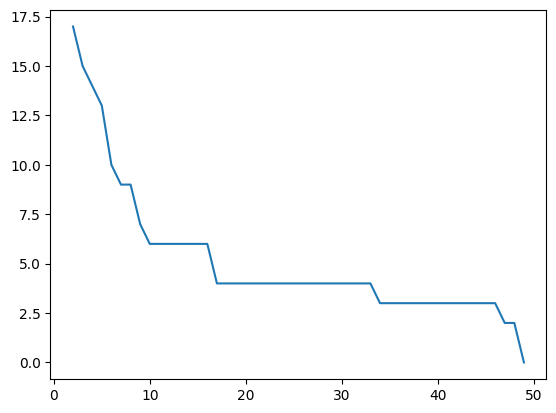

In [12]:
cluster_set = []
size_num = []
for i in range(2, 50):
    size_num.append(i)
    dbscan = hdbscan.HDBSCAN(min_samples=3, min_cluster_size =i, gen_min_span_tree=True, cluster_selection_epsilon =eps)
    cluster_lst = dbscan.fit(D)
    n_cluster = np.max(dbscan.labels_) + 1
    cluster_set.append(n_cluster)
    

plt.plot(size_num, cluster_set)

In [13]:
dbscan = hdbscan.HDBSCAN(min_samples=2, min_cluster_size =20, gen_min_span_tree=True, cluster_selection_epsilon =eps)
cluster_lst = dbscan.fit(D)
print(f"Trajectories are grouped into {np.max(dbscan.labels_) + 1} clusters")
print(f'DBI (0 means best): {metrics.davies_bouldin_score(D, dbscan.labels_):.3f}') 
print(f'silhouette_score (1 means better): {metrics.silhouette_score(D, dbscan.labels_):.3f}') 
print(f'Calinski-Harbasz Score (Larger means better): {metrics.calinski_harabasz_score(D, dbscan.labels_):.3f}') 
label = list(dbscan.labels_)

for i in range(0, np.max(dbscan.labels_) + 1):
    print(label.count(i))

Trajectories are grouped into 4 clusters
DBI (0 means best): 1.273
silhouette_score (1 means better): 0.382
Calinski-Harbasz Score (Larger means better): 90.109
47
50
65
33


In [17]:
plot_single_cluster(traj_collection_sc2gs_DP, dbscan.labels_, 3)

:Overlay
   .WMTS.I        :WMTS   [Longitude,Latitude]
   .Path.I        :Path   [Longitude,Latitude]
   .Points.I      :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.II       :WMTS   [Longitude,Latitude]
   .Path.II       :Path   [Longitude,Latitude]
   .Points.II     :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.III      :WMTS   [Longitude,Latitude]
   .Path.III      :Path   [Longitude,Latitude]
   .Points.III    :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.IV       :WMTS   [Longitude,Latitude]
   .Path.IV       :Path   [Longitude,Latitude]
   .Points.IV     :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.V        :WMTS   [Longitude,Latitude]
   .Path.V        :Path   [Longitude,Latitude]
   .Points.V      :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.VI       :WMTS   [Longitude,Latitude]
   .Path.VI       :Path   [Longitude,Latitude]
   .Points.VI     :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.VII      :WMTS   [Longitude,Latitude]
   .Path.VII      :Path   [Longitude,Latitude]
   .Points.VII    :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.VIII     :WMTS   [Longitude,Latitude]
   .Path.VIII     :Path   [Longitude,Latitude]
   .Points.VIII   :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.IX       :WMTS   [Longitude,Latitude]
   .Path.IX       :Path   [Longitude,Latitude]
   .Points.IX     :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.X        :WMTS   [Longitude,Latitude]
   .Path.X        :Path   [Longitude,Latitude]
   .Points.X      :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.XI       :WMTS   [Longitude,Latitude]
   .Path.XI       :Path   [Longitude,Latitude]
   .Points.XI     :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.XII      :WMTS   [Longitude,Latitude]
   .Path.XII      :Path   [Longitude,Latitude]
   .Points.XII    :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.XIII     :WMTS   [Longitude,Latitude]
   .Path.XIII     :Path   [Longitude,Latitude]
   .Points.XIII   :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.XIV      :WMTS   [Longitude,Latitude]
   .Path.XIV      :Path   [Longitude,Latitude]
   .Points.XIV    :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.XV       :WMTS   [Longitude,Latitude]
   .Path.XV       :Path   [Longitude,Latitude]
   .Points.XV     :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.XVI      :WMTS   [Longitude,Latitude]
   .Path.XVI      :Path   [Longitude,Latitude]
   .Points.XVI    :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.XVII     :WMTS   [Longitude,Latitude]
   .Path.XVII     :Path   [Longitude,Latitude]
   .Points.XVII   :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.XVIII    :WMTS   [Longitude,Latitude]
   .Path.XVIII    :Path   [Longitude,Latitude]
   .Points.XVIII  :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.XIX      :WMTS   [Longitude,Latitude]
   .Path.XIX      :Path   [Longitude,Latitude]
   .Points.XIX    :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.XX       :WMTS   [Longitude,Latitude]
   .Path.XX       :Path   [Longitude,Latitude]
   .Points.XX     :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.XXI      :WMTS   [Longitude,Latitude]
   .Path.XXI      :Path   [Longitude,Latitude]
   .Points.XXI    :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.XXII     :WMTS   [Longitude,Latitude]
   .Path.XXII     :Path   [Longitude,Latitude]
   .Points.XXII   :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.XXIII    :WMTS   [Longitude,Latitude]
   .Path.XXIII    :Path   [Longitude,Latitude]
   .Points.XXIII  :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.XXIV     :WMTS   [Longitude,Latitude]
   .Path.XXIV     :Path   [Longitude,Latitude]
   .Points.XXIV   :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.XXV      :WMTS   [Longitude,Latitude]
   .Path.XXV      :Path   [Longitude,Latitude]
   .Point

Text(0, 0.5, 'Latitude')

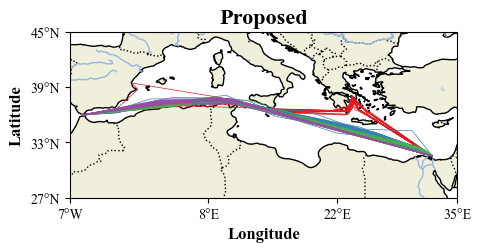

In [102]:
cluster_lst = dbscan.labels_
fig = plt.figure(figsize=(5,5))
colormp=plt.get_cmap('Set1')(range(5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
for k in range(max(dbscan.labels_)+1):
    ind = [x for x, y in list(enumerate(cluster_lst)) if y == k]
    traj_list = []
    for i in range(len(ind)):
        traj_list.append(traj_collection_sc2gs_DP.trajectories[ind[i]])
    traj_set = mpd.TrajectoryCollection(traj_list)
    ax = traj_set.plot(ax = ax, color=colormp[k], linewidth =  0.5)

ax.set_extent([-7, 35, 27, 45], crs=ccrs.PlateCarree())
# ax.stock_img()
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
SOURCE = 'Natural Earth'
LICENSE = 'public domain'
# ax.add_image(imagery)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(states_provinces, edgecolor='gray')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

fontlabel = {'family': 'times new roman',
        'color':  'black',
        'weight': 'bold',
        'size': 12,
        }
fonttitle = {'family': 'times new roman',
        'color':  'black',
        'weight': 'bold',
        'size': 16,
        }

ax.set_xticks([-7, 8, 22, 35], crs=ccrs.PlateCarree())
ax.set_yticks([27, 33, 39, 45], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
x1_label = ax.get_xticklabels() 
[x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
y1_label = ax.get_yticklabels() 
[y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label]
plt.title('Proposed', fontdict=fonttitle)
plt.xlabel('Longitude', fontdict=fontlabel)
plt.ylabel('Latitude', fontdict=fontlabel)

# fig.savefig('tempfigs/set_2_IHDBSCAN.png', dpi=600)

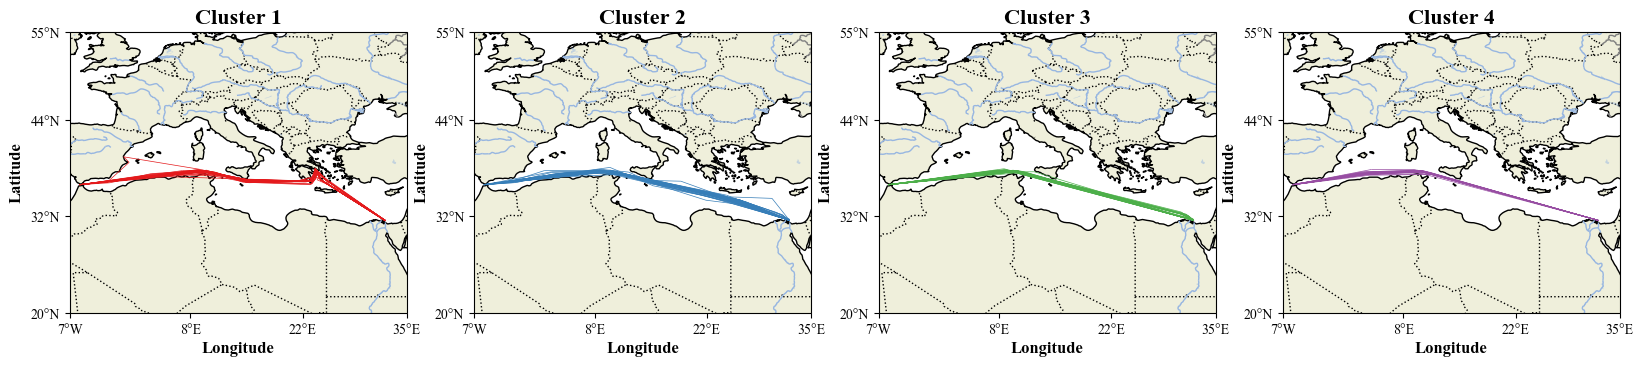

In [111]:
cluster_lst = dbscan.labels_
fig = plt.figure(figsize=(20,4))
colormp=plt.get_cmap('Set1')(range(5))
for k in range(max(dbscan.labels_)+1):
    ind = [x for x, y in list(enumerate(cluster_lst)) if y == k]
    traj_list = []
    for i in range(len(ind)):
        traj_list.append(traj_collection_sc2gs_DP.trajectories[ind[i]])
    traj_set = mpd.TrajectoryCollection(traj_list)
    ax = fig.add_subplot(1, 4, k+1, projection=ccrs.PlateCarree())
    ax = traj_set.plot(ax = ax, color=colormp[k], linewidth =  0.5)
    ax.set_extent([-7, 35, 20, 55], crs=ccrs.PlateCarree())
    # ax.stock_img()
    states_provinces = cfeature.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces_lines',
            scale='50m',
            facecolor='none')
    SOURCE = 'Natural Earth'
    LICENSE = 'public domain'
    # ax.add_image(imagery)
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(states_provinces, edgecolor='gray')
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)

    fontlabel = {'family': 'times new roman',
            'color':  'black',
            'weight': 'bold',
            'size': 12,
            }
    fonttitle = {'family': 'times new roman',
            'color':  'black',
            'weight': 'bold',
            'size': 16,
            }

    ax.set_xticks([-7, 8, 22, 35], crs=ccrs.PlateCarree())
    ax.set_yticks([20, 32, 44, 55], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    x1_label = ax.get_xticklabels() 
    [x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
    y1_label = ax.get_yticklabels() 
    [y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label]
    plt.title('Cluster %d' % (k+1), fontdict=fonttitle)
    plt.xlabel('Longitude', fontdict=fontlabel)
    plt.ylabel('Latitude', fontdict=fontlabel)

    fig.savefig('tempfigs/cluster_set_2_IHDBSCAN.png', dpi=600)


### HDBSCAN

In [43]:
traj_collection_sc2gs_DP = DPcompression(traj_collection_sc2gs, 0.3)
gdf_sc2gs_DP = traj_collection_sc2gs_DP.to_traj_gdf()

traj_list = df2list(gdf_sc2gs_DP)
traj_count = len(traj_list)
D_h = np.zeros((traj_count, traj_count))

# This may take a while
for i in range(traj_count):
    for j in range(i + 1, traj_count):
        distance1 = hausdorff_distance(traj_list[i], traj_list[j], distance='haversine')
        D_h[i, j] = distance1
        D_h[j, i] = distance1

eps = find_eps(3, D_h)

Generating 253 trajectories in array form
The best eps value is 117.1598671545287


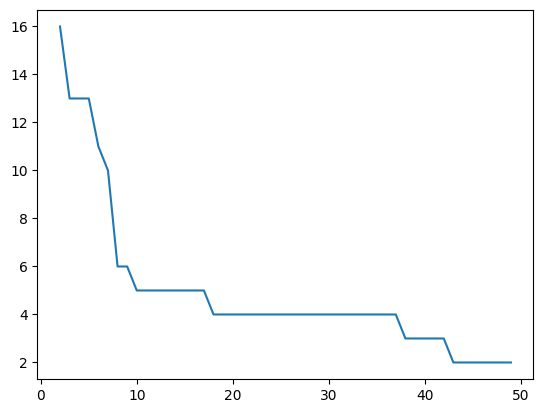

In [44]:
cluster_set = []
size_num = []
for i in range(2, 50):
    size_num.append(i)
    dbscan = hdbscan.HDBSCAN(min_samples=3, min_cluster_size =i, gen_min_span_tree=True, cluster_selection_epsilon =eps)
    cluster_lst = dbscan.fit(D_h)
    n_cluster = np.max(dbscan.labels_) + 1
    cluster_set.append(n_cluster)
    

plt.plot(size_num, cluster_set)

In [45]:
dbscan = hdbscan.HDBSCAN(min_samples=3, min_cluster_size =5,cluster_selection_epsilon =eps)
cluster_lst = dbscan.fit(D_h)
print(f"Trajectories are grouped into {np.max(dbscan.labels_) + 1} clusters")
print(f'DBI (0 means best): {metrics.davies_bouldin_score(D_h, dbscan.labels_):.3f}') 
print(f'SS (1 means better): {metrics.silhouette_score(D_h, dbscan.labels_):.3f}') 
print(f'Calinski-Harbasz Score (Larger means better): {metrics.calinski_harabasz_score(D_h, dbscan.labels_):.3f}') 

Trajectories are grouped into 13 clusters
DBI (0 means best): 1.253
SS (1 means better): 0.270
Calinski-Harbasz Score (Larger means better): 78.819


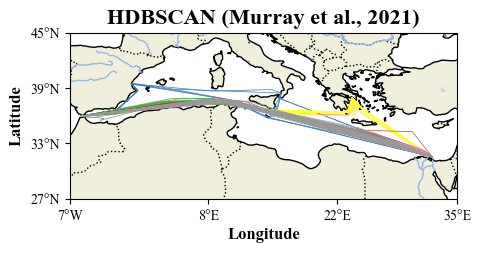

In [47]:
cluster_lst = dbscan.labels_
fig = plt.figure(figsize=(5,5))
colormp=plt.get_cmap('Set1')(range(13))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
for k in range(max(dbscan.labels_)+1):
    ind = [x for x, y in list(enumerate(cluster_lst)) if y == k]
    traj_list = []
    for i in range(len(ind)):
        traj_list.append(traj_collection_sc2gs_DP.trajectories[ind[i]])
    traj_set = mpd.TrajectoryCollection(traj_list)
    ax = traj_set.plot(ax = ax, color=colormp[k], linewidth =  0.5)

ax.set_extent([-7, 35, 27, 45], crs=ccrs.PlateCarree())
# ax.stock_img()
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
SOURCE = 'Natural Earth'
LICENSE = 'public domain'
# ax.add_image(imagery)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(states_provinces, edgecolor='gray')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

fontlabel = {'family': 'times new roman',
        'color':  'black',
        'weight': 'bold',
        'size': 12,
        }
fonttitle = {'family': 'times new roman',
        'color':  'black',
        'weight': 'bold',
        'size': 16,
        }

ax.set_xticks([-7, 8, 22, 35], crs=ccrs.PlateCarree())
ax.set_yticks([27, 33, 39, 45], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
x1_label = ax.get_xticklabels() 
[x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
y1_label = ax.get_yticklabels() 
[y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label]
plt.title('HDBSCAN (Murray et al., 2021)', fontdict=fonttitle)
plt.xlabel('Longitude', fontdict=fontlabel)
plt.ylabel('Latitude', fontdict=fontlabel)

fig.savefig('tempfigs/set_2_HDBSCAN.png', dpi=600)


### DBTCAN

In [36]:
traj_collection_sc2gs_DP = DPcompression(traj_collection_sc2gs, 0.3)
gdf_sc2gs_DP = traj_collection_sc2gs_DP.to_traj_gdf()

traj_list = df2list(gdf_sc2gs_DP)
traj_count = len(traj_list)
D_h = np.zeros((traj_count, traj_count))
# This may take a while
for i in range(traj_count):
    for j in range(i + 1, traj_count):
        distance1 = hausdorff_distance(traj_list[i], traj_list[j], distance='haversine')
        D_h[i, j] = distance1
        D_h[j, i] = distance1
eps_set = []
for i in range(2, 20):
    eps_set.append(find_eps(i, D_h))

eps_set

Generating 253 trajectories in array form
The best eps value is 18.246961553390868
The best eps value is 117.1598671545287
The best eps value is 50.18634591090965
The best eps value is 55.951673698059125
The best eps value is 143.38741017455317
The best eps value is 49.722621211053756
The best eps value is 75.46862307156775
The best eps value is 62.68232864614668
The best eps value is 72.85066291468438
The best eps value is 76.10927199135695
The best eps value is 81.32337812803434
The best eps value is 75.46862307156775
The best eps value is 79.72620148705512
The best eps value is 86.9250064982123
The best eps value is 99.78958386424104
The best eps value is 130.0922316504526
The best eps value is 126.07683698593353
The best eps value is 131.38197669925748


[18.246961553390868,
 117.1598671545287,
 50.18634591090965,
 55.951673698059125,
 143.38741017455317,
 49.722621211053756,
 75.46862307156775,
 62.68232864614668,
 72.85066291468438,
 76.10927199135695,
 81.32337812803434,
 75.46862307156775,
 79.72620148705512,
 86.9250064982123,
 99.78958386424104,
 130.0922316504526,
 126.07683698593353,
 131.38197669925748]

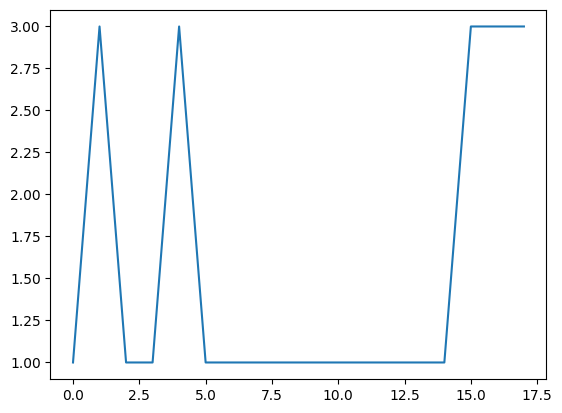

In [37]:
cluster_set = []
size_num = []
for i in range(0, len(eps_set)):
    size_num.append(i)
    mdl = DBSCAN(eps=eps_set[i], min_samples=4)
    cluster_lst = mdl.fit_predict(D_h)
    n_cluster = np.max(cluster_lst) + 1
    cluster_set.append(n_cluster)
    

plt.plot(size_num, cluster_set)

In [39]:

mdl = DBSCAN(eps=eps_set[4], min_samples=3)
cluster_lst = mdl.fit_predict(D_h)
print(f"Trajectories are grouped into {np.max(cluster_lst) + 1} clusters")
print(f'DBI (0 means best): {metrics.davies_bouldin_score(D_h, cluster_lst):.3f}') 
print(f'SS (1 means better): {metrics.silhouette_score(D_h, cluster_lst):.3f}') 
print(f'Calinski-Harbasz Score (Larger means better): {metrics.calinski_harabasz_score(D_h, cluster_lst):.3f}') 

Trajectories are grouped into 9 clusters
DBI (0 means best): 0.903
SS (1 means better): -0.291
Calinski-Harbasz Score (Larger means better): 13.378


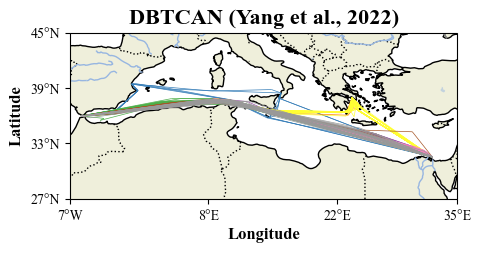

In [42]:
cluster_lst = dbscan.labels_
fig = plt.figure(figsize=(5,5))
colormp=plt.get_cmap('Set1')(range(13))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
for k in range(max(dbscan.labels_)+1):
    ind = [x for x, y in list(enumerate(cluster_lst)) if y == k]
    traj_list = []
    for i in range(len(ind)):
        traj_list.append(traj_collection_sc2gs_DP.trajectories[ind[i]])
    traj_set = mpd.TrajectoryCollection(traj_list)
    ax = traj_set.plot(ax = ax, color=colormp[k], linewidth =  0.5)

ax.set_extent([-7, 35, 27, 45], crs=ccrs.PlateCarree())
# ax.stock_img()
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
SOURCE = 'Natural Earth'
LICENSE = 'public domain'
# ax.add_image(imagery)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(states_provinces, edgecolor='gray')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

fontlabel = {'family': 'times new roman',
        'color':  'black',
        'weight': 'bold',
        'size': 12,
        }
fonttitle = {'family': 'times new roman',
        'color':  'black',
        'weight': 'bold',
        'size': 16,
        }

ax.set_xticks([-7, 8, 22, 35], crs=ccrs.PlateCarree())
ax.set_yticks([27, 33, 39, 45], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
x1_label = ax.get_xticklabels() 
[x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
y1_label = ax.get_yticklabels() 
[y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label]
plt.title('DBTCAN (Yang et al., 2022)', fontdict=fonttitle)
plt.xlabel('Longitude', fontdict=fontlabel)
plt.ylabel('Latitude', fontdict=fontlabel)

fig.savefig('tempfigs/set_2_DBTCAN.png', dpi=600)

### DBSCAN

In [ ]:
traj_collection_sc2gs_DP = DPcompression(traj_collection_sc2gs, 0.4)
gdf_sc2gs_DP = traj_collection_sc2gs_DP.to_traj_gdf()

traj_list = df2list(gdf_sc2gs_DP)
traj_count = len(traj_list)
D = np.zeros((traj_count, traj_count))
# This may take a while
for i in range(traj_count):
    for j in range(i + 1, traj_count):
        distance1 = dtw(traj_list[i], traj_list[j], dist_method = haversine_dist, distance_only=True)
        D[i, j] = distance1.distance
        D[j, i] = distance1.distance

eps = find_eps(5, D)

In [50]:
mdl = DBSCAN(eps=eps, min_samples=3)
cluster_lst = mdl.fit_predict(D_h)
print(f"Trajectories are grouped into {np.max(cluster_lst) + 1} clusters")
print(f'DBI (0 means best): {metrics.davies_bouldin_score(D, cluster_lst):.3f}') 
print(f'SS (1 means better): {metrics.silhouette_score(D, cluster_lst):.3f}') 
print(f'Calinski-Harbasz Score (Larger means better): {metrics.calinski_harabasz_score(D, cluster_lst):.3f}') 

Trajectories are grouped into 5 clusters
DBI (0 means best): 1.029
SS (1 means better): -0.327
Calinski-Harbasz Score (Larger means better): 7.278


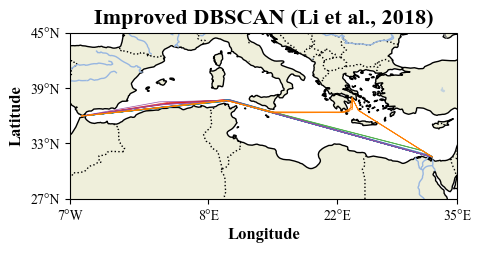

In [53]:
# cluster_lst = dbscan.labels_
fig = plt.figure(figsize=(5,5))
colormp=plt.get_cmap('Set1')(range(13))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
for k in range(max(cluster_lst)+1):
    ind = [x for x, y in list(enumerate(cluster_lst)) if y == k]
    traj_list = []
    for i in range(len(ind)):
        traj_list.append(traj_collection_sc2gs_DP.trajectories[ind[i]])
    traj_set = mpd.TrajectoryCollection(traj_list)
    ax = traj_set.plot(ax = ax, color=colormp[k], linewidth =  0.5)

ax.set_extent([-7, 35, 27, 45], crs=ccrs.PlateCarree())
# ax.stock_img()
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
SOURCE = 'Natural Earth'
LICENSE = 'public domain'
# ax.add_image(imagery)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(states_provinces, edgecolor='gray')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

fontlabel = {'family': 'times new roman',
        'color':  'black',
        'weight': 'bold',
        'size': 12,
        }
fonttitle = {'family': 'times new roman',
        'color':  'black',
        'weight': 'bold',
        'size': 16,
        }

ax.set_xticks([-7, 8, 22, 35], crs=ccrs.PlateCarree())
ax.set_yticks([27, 33, 39, 45], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
x1_label = ax.get_xticklabels() 
[x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
y1_label = ax.get_yticklabels() 
[y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label]
plt.title('Improved DBSCAN (Li et al., 2018)', fontdict=fonttitle)
plt.xlabel('Longitude', fontdict=fontlabel)
plt.ylabel('Latitude', fontdict=fontlabel)

fig.savefig('tempfigs/set_2_DBSCAN.png', dpi=600)

### Trajectories from GS to Suez Canal

In [18]:
traj_collection_gs2sc = mpd.TrajectoryCollection(traj_list_gs2sc)
traj_collection_gs2sc_DP = DPcompression(traj_collection_gs2sc, 0.3)
# similarity measurements using DTW
gdf_gs2sc_DP = traj_collection_gs2sc_DP.to_traj_gdf()
traj_list = df2list(gdf_gs2sc_DP)
traj_count = len(traj_list)
D = np.zeros((traj_count, traj_count))
# This may take a while
for i in range(traj_count):
    for j in range(i + 1, traj_count):
        distance1 = dtw(traj_list[i], traj_list[j], dist_method = haversine_dist, distance_only=True)
        D[i, j] = distance1.distance
        D[j, i] = distance1.distance

    
eps = find_eps(3, D)


Generating 220 trajectories in array form
The best eps value is 58.444291251593796


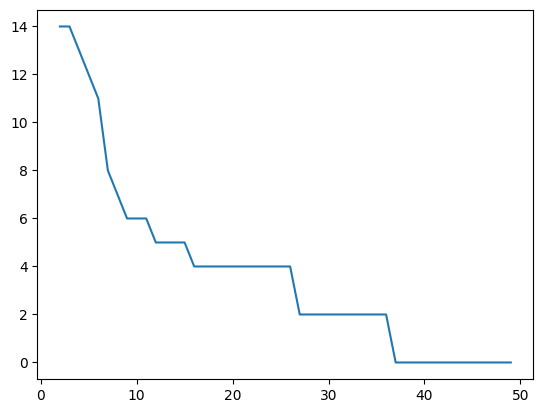

In [19]:
cluster_set = []
size_num = []
for i in range(2, 50):
    size_num.append(i)
    dbscan = hdbscan.HDBSCAN(min_samples=3, min_cluster_size =i, gen_min_span_tree=True, cluster_selection_epsilon =eps)
    cluster_lst = dbscan.fit(D)
    n_cluster = np.max(dbscan.labels_) + 1
    cluster_set.append(n_cluster)
    

plt.plot(size_num, cluster_set)


In [20]:
dbscan = hdbscan.HDBSCAN(min_samples=2, min_cluster_size =20, gen_min_span_tree=True, cluster_selection_epsilon =eps)
cluster_lst = dbscan.fit(D)
print(f"Trajectories are grouped into {np.max(dbscan.labels_) + 1} clusters")
print(f"Trajectories are grouped into {np.max(dbscan.labels_) + 1} clusters")
print(f'DBI (0 means best): {metrics.davies_bouldin_score(D, dbscan.labels_):.3f}') 
print(f'silhouette_score (1 means better): {metrics.silhouette_score(D, dbscan.labels_):.3f}') 
print(f'Calinski-Harbasz Score (Larger means better): {metrics.calinski_harabasz_score(D, dbscan.labels_):.3f}') 
label = list(dbscan.labels_)

for i in range(0, np.max(dbscan.labels_) + 1):
    print(label.count(i))

Trajectories are grouped into 4 clusters
Trajectories are grouped into 4 clusters
DBI (0 means best): 1.290
silhouette_score (1 means better): 0.454
Calinski-Harbasz Score (Larger means better): 125.237
26
43
78
28


In [24]:
plot_single_cluster(traj_collection_gs2sc_DP, dbscan.labels_,3)

:Overlay
   .WMTS.I        :WMTS   [Longitude,Latitude]
   .Path.I        :Path   [Longitude,Latitude]
   .Points.I      :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.II       :WMTS   [Longitude,Latitude]
   .Path.II       :Path   [Longitude,Latitude]
   .Points.II     :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.III      :WMTS   [Longitude,Latitude]
   .Path.III      :Path   [Longitude,Latitude]
   .Points.III    :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.IV       :WMTS   [Longitude,Latitude]
   .Path.IV       :Path   [Longitude,Latitude]
   .Points.IV     :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.V        :WMTS   [Longitude,Latitude]
   .Path.V        :Path   [Longitude,Latitude]
   .Points.V      :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.VI       :WMTS   [Longitude,Latitude]
   .Path.VI       :Path   [Longitude,Latitude]
   .Points.VI     :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.VII      :WMTS   [Longitude,Latitude]
   .Path.VII      :Path   [Longitude,Latitude]
   .Points.VII    :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.VIII     :WMTS   [Longitude,Latitude]
   .Path.VIII     :Path   [Longitude,Latitude]
   .Points.VIII   :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.IX       :WMTS   [Longitude,Latitude]
   .Path.IX       :Path   [Longitude,Latitude]
   .Points.IX     :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.X        :WMTS   [Longitude,Latitude]
   .Path.X        :Path   [Longitude,Latitude]
   .Points.X      :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.XI       :WMTS   [Longitude,Latitude]
   .Path.XI       :Path   [Longitude,Latitude]
   .Points.XI     :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.XII      :WMTS   [Longitude,Latitude]
   .Path.XII      :Path   [Longitude,Latitude]
   .Points.XII    :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.XIII     :WMTS   [Longitude,Latitude]
   .Path.XIII     :Path   [Longitude,Latitude]
   .Points.XIII   :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.XIV      :WMTS   [Longitude,Latitude]
   .Path.XIV      :Path   [Longitude,Latitude]
   .Points.XIV    :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.XV       :WMTS   [Longitude,Latitude]
   .Path.XV       :Path   [Longitude,Latitude]
   .Points.XV     :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.XVI      :WMTS   [Longitude,Latitude]
   .Path.XVI      :Path   [Longitude,Latitude]
   .Points.XVI    :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.XVII     :WMTS   [Longitude,Latitude]
   .Path.XVII     :Path   [Longitude,Latitude]
   .Points.XVII   :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.XVIII    :WMTS   [Longitude,Latitude]
   .Path.XVIII    :Path   [Longitude,Latitude]
   .Points.XVIII  :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.XIX      :WMTS   [Longitude,Latitude]
   .Path.XIX      :Path   [Longitude,Latitude]
   .Points.XIX    :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.XX       :WMTS   [Longitude,Latitude]
   .Path.XX       :Path   [Longitude,Latitude]
   .Points.XX     :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.XXI      :WMTS   [Longitude,Latitude]
   .Path.XXI      :Path   [Longitude,Latitude]
   .Points.XXI    :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.XXII     :WMTS   [Longitude,Latitude]
   .Path.XXII     :Path   [Longitude,Latitude]
   .Points.XXII   :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.XXIII    :WMTS   [Longitude,Latitude]
   .Path.XXIII    :Path   [Longitude,Latitude]
   .Points.XXIII  :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.XXIV     :WMTS   [Longitude,Latitude]
   .Path.XXIV     :Path   [Longitude,Latitude]
   .Points.XXIV   :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.XXV      :WMTS   [Longitude,Latitude]
   .Path.XXV      :Path   [Longitude,Latitude]
   .Point

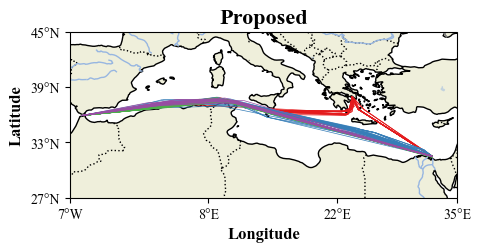

In [8]:
cluster_lst = dbscan.labels_
fig = plt.figure(figsize=(5,5))
colormp=plt.get_cmap('Set1')(range(5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
for k in range(max(dbscan.labels_)+1):
    ind = [x for x, y in list(enumerate(cluster_lst)) if y == k]
    traj_list = []
    for i in range(len(ind)):
        traj_list.append(traj_collection_gs2sc_DP.trajectories[ind[i]])
    traj_set = mpd.TrajectoryCollection(traj_list)
    ax = traj_set.plot(ax = ax, color=colormp[k], linewidth =  0.5)

ax.set_extent([-7, 35, 27, 45], crs=ccrs.PlateCarree())
# ax.stock_img()
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
SOURCE = 'Natural Earth'
LICENSE = 'public domain'
# ax.add_image(imagery)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(states_provinces, edgecolor='gray')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

fontlabel = {'family': 'times new roman',
        'color':  'black',
        'weight': 'bold',
        'size': 12,
        }
fonttitle = {'family': 'times new roman',
        'color':  'black',
        'weight': 'bold',
        'size': 16,
        }

ax.set_xticks([-7, 8, 22, 35], crs=ccrs.PlateCarree())
ax.set_yticks([27, 33, 39, 45], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
x1_label = ax.get_xticklabels() 
[x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
y1_label = ax.get_yticklabels() 
[y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label]
plt.title('Proposed', fontdict=fonttitle)
plt.xlabel('Longitude', fontdict=fontlabel)
plt.ylabel('Latitude', fontdict=fontlabel)

fig.savefig('tempfigs/set_2b_IHDBSCAN.png', dpi=600)

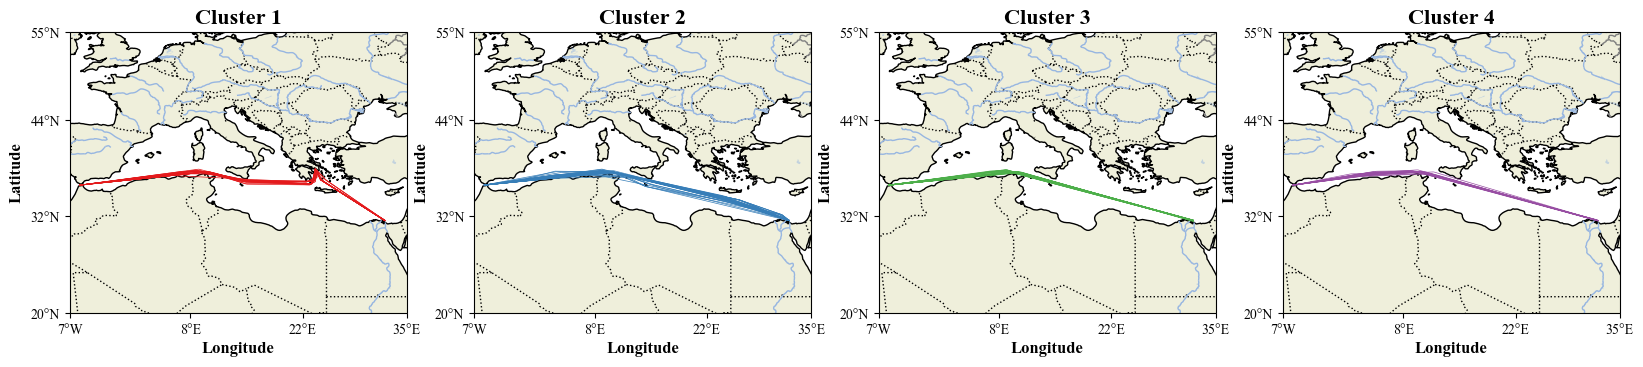

In [10]:
cluster_lst = dbscan.labels_
fig = plt.figure(figsize=(20,4))
colormp=plt.get_cmap('Set1')(range(5))
for k in range(max(dbscan.labels_)+1):
    ind = [x for x, y in list(enumerate(cluster_lst)) if y == k]
    traj_list = []
    for i in range(len(ind)):
        traj_list.append(traj_collection_gs2sc_DP.trajectories[ind[i]])
    traj_set = mpd.TrajectoryCollection(traj_list)
    ax = fig.add_subplot(1, 4, k+1, projection=ccrs.PlateCarree())
    ax = traj_set.plot(ax = ax, color=colormp[k], linewidth =  0.5)
    ax.set_extent([-7, 35, 20, 55], crs=ccrs.PlateCarree())
    # ax.stock_img()
    states_provinces = cfeature.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces_lines',
            scale='50m',
            facecolor='none')
    SOURCE = 'Natural Earth'
    LICENSE = 'public domain'
    # ax.add_image(imagery)
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(states_provinces, edgecolor='gray')
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)

    fontlabel = {'family': 'times new roman',
            'color':  'black',
            'weight': 'bold',
            'size': 12,
            }
    fonttitle = {'family': 'times new roman',
            'color':  'black',
            'weight': 'bold',
            'size': 16,
            }

    ax.set_xticks([-7, 8, 22, 35], crs=ccrs.PlateCarree())
    ax.set_yticks([20, 32, 44, 55], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    x1_label = ax.get_xticklabels() 
    [x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
    y1_label = ax.get_yticklabels() 
    [y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label]
    plt.title('Cluster %d' % (k+1), fontdict=fonttitle)
    plt.xlabel('Longitude', fontdict=fontlabel)
    plt.ylabel('Latitude', fontdict=fontlabel)

fig.savefig('tempfigs/cluster_set_2b_IHDBSCAN.png', dpi=600)

    

### HDBSCAN

In [70]:
traj_collection_gs2sc_DP = DPcompression(traj_collection_gs2sc, 0.3)
gdf_gs2sc_DP = traj_collection_gs2sc_DP.to_traj_gdf()

traj_list = df2list(gdf_gs2sc_DP)
traj_count = len(traj_list)
D_h = np.zeros((traj_count, traj_count))

# This may take a while
for i in range(traj_count):
    for j in range(i + 1, traj_count):
        distance1 = hausdorff_distance(traj_list[i], traj_list[j], distance='haversine')
        D_h[i, j] = distance1
        D_h[j, i] = distance1

eps = find_eps(3, D_h)

Generating 220 trajectories in array form
The best eps value is 18.723032420100417


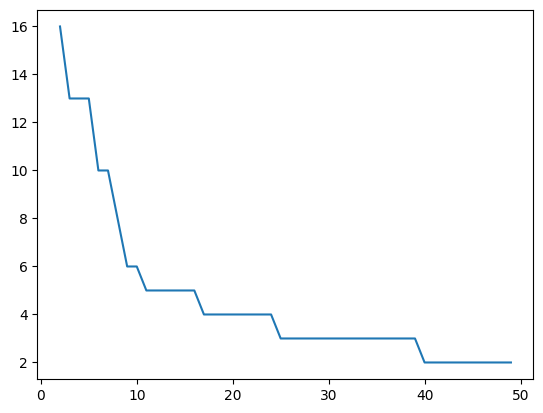

In [71]:
cluster_set = []
size_num = []
for i in range(2, 50):
    size_num.append(i)
    dbscan = hdbscan.HDBSCAN(min_samples=3, min_cluster_size =i, gen_min_span_tree=True, cluster_selection_epsilon =eps)
    cluster_lst = dbscan.fit(D_h)
    n_cluster = np.max(dbscan.labels_) + 1
    cluster_set.append(n_cluster)
    

plt.plot(size_num, cluster_set)

In [82]:
dbscan = hdbscan.HDBSCAN(min_samples=3, min_cluster_size =6,cluster_selection_epsilon =eps)
cluster_lst = dbscan.fit(D_h)
print(f"Trajectories are grouped into {np.max(dbscan.labels_) + 1} clusters")
print(f'DBI (0 means best): {metrics.davies_bouldin_score(D_h, dbscan.labels_):.3f}') 
print(f'SS (1 means better): {metrics.silhouette_score(D_h, dbscan.labels_):.3f}') 
print(f'Calinski-Harbasz Score (Larger means better): {metrics.calinski_harabasz_score(D_h, dbscan.labels_):.3f}') 

Trajectories are grouped into 10 clusters
DBI (0 means best): 1.274
SS (1 means better): 0.404
Calinski-Harbasz Score (Larger means better): 136.730


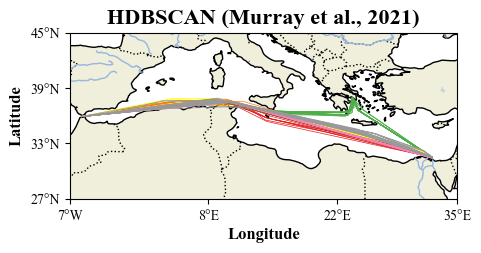

In [85]:
cluster_lst = dbscan.labels_
fig = plt.figure(figsize=(5,5))
colormp=plt.get_cmap('Set1')(range(10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
for k in range(max(dbscan.labels_)+1):
    ind = [x for x, y in list(enumerate(cluster_lst)) if y == k]
    traj_list = []
    for i in range(len(ind)):
        traj_list.append(traj_collection_gs2sc_DP.trajectories[ind[i]])
    traj_set = mpd.TrajectoryCollection(traj_list)
    ax = traj_set.plot(ax = ax, color=colormp[k], linewidth =  0.5)

ax.set_extent([-7, 35, 27, 45], crs=ccrs.PlateCarree())
# ax.stock_img()
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
SOURCE = 'Natural Earth'
LICENSE = 'public domain'
# ax.add_image(imagery)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(states_provinces, edgecolor='gray')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

fontlabel = {'family': 'times new roman',
        'color':  'black',
        'weight': 'bold',
        'size': 12,
        }
fonttitle = {'family': 'times new roman',
        'color':  'black',
        'weight': 'bold',
        'size': 16,
        }

ax.set_xticks([-7, 8, 22, 35], crs=ccrs.PlateCarree())
ax.set_yticks([27, 33, 39, 45], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
x1_label = ax.get_xticklabels() 
[x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
y1_label = ax.get_yticklabels() 
[y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label]
plt.title('HDBSCAN (Murray et al., 2021)', fontdict=fonttitle)
plt.xlabel('Longitude', fontdict=fontlabel)
plt.ylabel('Latitude', fontdict=fontlabel)

fig.savefig('tempfigs/set_2b_HDBSCAN.png', dpi=600)

### DBTCAN

In [86]:
traj_collection_gs2sc_DP = DPcompression(traj_collection_gs2sc, 0.3)
gdf_gs2sc_DP = traj_collection_gs2sc_DP.to_traj_gdf()

traj_list = df2list(gdf_gs2sc_DP)
traj_count = len(traj_list)
D_h = np.zeros((traj_count, traj_count))
# This may take a while
for i in range(traj_count):
    for j in range(i + 1, traj_count):
        distance1 = hausdorff_distance(traj_list[i], traj_list[j], distance='haversine')
        D_h[i, j] = distance1
        D_h[j, i] = distance1
eps_set = []
for i in range(2, 20):
    eps_set.append(find_eps(i, D_h))

eps_set

Generating 220 trajectories in array form
The best eps value is 11.524936673549973
The best eps value is 18.723032420100417
The best eps value is 17.736632792814795
The best eps value is 20.2142554786336
The best eps value is 29.138861448396312
The best eps value is 31.82421759088827
The best eps value is 35.38112885922413
The best eps value is 33.44766030094041
The best eps value is 32.5325630410373
The best eps value is 36.72299974197902
The best eps value is 38.091306070536795
The best eps value is 39.46383757839228
The best eps value is 45.44246339826694
The best eps value is 45.36990859757748
The best eps value is 49.17084338054835
The best eps value is 56.40235950996289
The best eps value is 60.3083554271884
The best eps value is 61.43922194496126


[11.524936673549973,
 18.723032420100417,
 17.736632792814795,
 20.2142554786336,
 29.138861448396312,
 31.82421759088827,
 35.38112885922413,
 33.44766030094041,
 32.5325630410373,
 36.72299974197902,
 38.091306070536795,
 39.46383757839228,
 45.44246339826694,
 45.36990859757748,
 49.17084338054835,
 56.40235950996289,
 60.3083554271884,
 61.43922194496126]

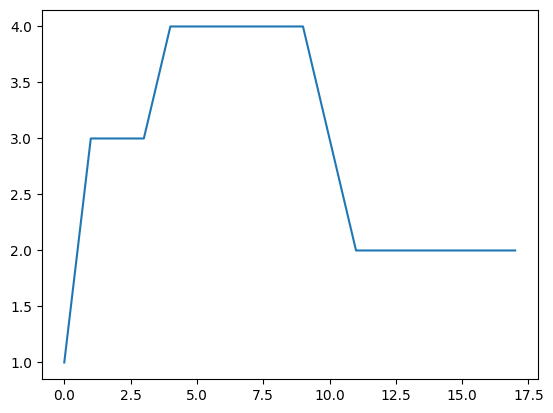

In [87]:
cluster_set = []
size_num = []
for i in range(0, len(eps_set)):
    size_num.append(i)
    mdl = DBSCAN(eps=eps_set[i], min_samples=4)
    cluster_lst = mdl.fit_predict(D_h)
    n_cluster = np.max(cluster_lst) + 1
    cluster_set.append(n_cluster)
    

plt.plot(size_num, cluster_set)


In [88]:
mdl = DBSCAN(eps=eps_set[5], min_samples=3)
cluster_lst = mdl.fit_predict(D_h)
print(f"Trajectories are grouped into {np.max(cluster_lst) + 1} clusters")
print(f'DBI (0 means best): {metrics.davies_bouldin_score(D_h, cluster_lst):.3f}') 
print(f'SS (1 means better): {metrics.silhouette_score(D_h, cluster_lst):.3f}') 
print(f'Calinski-Harbasz Score (Larger means better): {metrics.calinski_harabasz_score(D_h, cluster_lst):.3f}') 



Trajectories are grouped into 5 clusters
DBI (0 means best): 0.798
SS (1 means better): 0.067
Calinski-Harbasz Score (Larger means better): 13.529


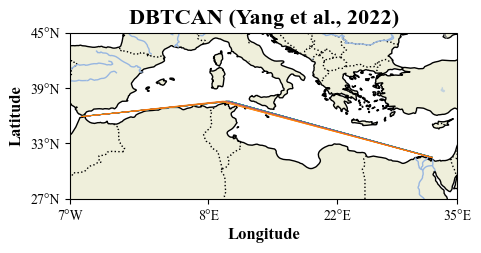

In [91]:

fig = plt.figure(figsize=(5,5))
colormp=plt.get_cmap('Set1')(range(10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
for k in range(max(cluster_lst)+1):
    ind = [x for x, y in list(enumerate(cluster_lst)) if y == k]
    traj_list = []
    for i in range(len(ind)):
        traj_list.append(traj_collection_gs2sc_DP.trajectories[ind[i]])
    traj_set = mpd.TrajectoryCollection(traj_list)
    ax = traj_set.plot(ax = ax, color=colormp[k], linewidth =  0.5)

ax.set_extent([-7, 35, 27, 45], crs=ccrs.PlateCarree())
# ax.stock_img()
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
SOURCE = 'Natural Earth'
LICENSE = 'public domain'
# ax.add_image(imagery)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(states_provinces, edgecolor='gray')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

fontlabel = {'family': 'times new roman',
        'color':  'black',
        'weight': 'bold',
        'size': 12,
        }
fonttitle = {'family': 'times new roman',
        'color':  'black',
        'weight': 'bold',
        'size': 16,
        }

ax.set_xticks([-7, 8, 22, 35], crs=ccrs.PlateCarree())
ax.set_yticks([27, 33, 39, 45], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
x1_label = ax.get_xticklabels() 
[x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
y1_label = ax.get_yticklabels() 
[y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label]
plt.title('DBTCAN (Yang et al., 2022)', fontdict=fonttitle)
plt.xlabel('Longitude', fontdict=fontlabel)
plt.ylabel('Latitude', fontdict=fontlabel)

fig.savefig('tempfigs/set_2b_DBTCAN.png', dpi=600)

### DBSCAN

In [95]:
traj_collection_gs2sc_DP = DPcompression(traj_collection_gs2sc, 0.3)
gdf_gs2sc_DP = traj_collection_gs2sc_DP.to_traj_gdf()

traj_list = df2list(gdf_gs2sc_DP)

traj_count = len(traj_list)
D = np.zeros((traj_count, traj_count))
# This may take a while
for i in range(traj_count):
    for j in range(i + 1, traj_count):
        distance1 = dtw(traj_list[i], traj_list[j], dist_method = haversine_dist, distance_only=True)
        D[i, j] = distance1.distance
        D[j, i] = distance1.distance

eps = find_eps(5, D)

Generating 220 trajectories in array form
The best eps value is 74.32864805514255


In [96]:
mdl = DBSCAN(eps=eps, min_samples=3)
cluster_lst = mdl.fit_predict(D)
print(f"Trajectories are grouped into {np.max(cluster_lst) + 1} clusters")
print(f'DBI (0 means best): {metrics.davies_bouldin_score(D, cluster_lst):.3f}') 
print(f'SS (1 means better): {metrics.silhouette_score(D, cluster_lst):.3f}') 
print(f'Calinski-Harbasz Score (Larger means better): {metrics.calinski_harabasz_score(D, cluster_lst):.3f}') 

Trajectories are grouped into 4 clusters
DBI (0 means best): 1.198
SS (1 means better): -0.303
Calinski-Harbasz Score (Larger means better): 2.079


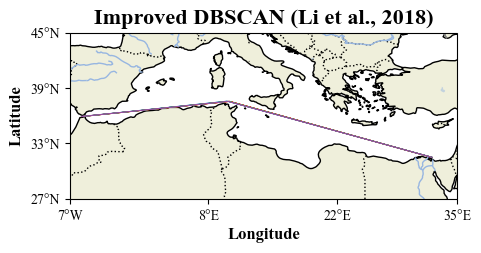

In [98]:
fig = plt.figure(figsize=(5,5))
colormp=plt.get_cmap('Set1')(range(10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
for k in range(max(cluster_lst)+1):
    ind = [x for x, y in list(enumerate(cluster_lst)) if y == k]
    traj_list = []
    for i in range(len(ind)):
        traj_list.append(traj_collection_gs2sc_DP.trajectories[ind[i]])
    traj_set = mpd.TrajectoryCollection(traj_list)
    ax = traj_set.plot(ax = ax, color=colormp[k], linewidth =  0.5)

ax.set_extent([-7, 35, 27, 45], crs=ccrs.PlateCarree())
# ax.stock_img()
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
SOURCE = 'Natural Earth'
LICENSE = 'public domain'
# ax.add_image(imagery)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(states_provinces, edgecolor='gray')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

fontlabel = {'family': 'times new roman',
        'color':  'black',
        'weight': 'bold',
        'size': 12,
        }
fonttitle = {'family': 'times new roman',
        'color':  'black',
        'weight': 'bold',
        'size': 16,
        }

ax.set_xticks([-7, 8, 22, 35], crs=ccrs.PlateCarree())
ax.set_yticks([27, 33, 39, 45], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
x1_label = ax.get_xticklabels() 
[x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
y1_label = ax.get_yticklabels() 
[y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label]
plt.title('Improved DBSCAN (Li et al., 2018)', fontdict=fonttitle)
plt.xlabel('Longitude', fontdict=fontlabel)
plt.ylabel('Latitude', fontdict=fontlabel)

fig.savefig('tempfigs/set_2b_DBSCAN.png', dpi=600)


### Clustering results

### Traffic flow analysis

In [4]:
traj_DP = DPcompression(traj, 0.5)

In [5]:
from OD_cluster import *
aggregator = OD_cluster(traj_DP, max_distance=10, min_distance=1,min_stop_duration=timedelta(hours=12))
flows = aggregator.get_flows_gdf()
clusters = aggregator.return_clusters_gdf()

Extracting significant points ...


In [6]:
dosize = clusters.n*3

In [96]:
points = clusters.geometry
xs = [point.x for point in points]
ys = [point.y for point in points]
df = pd.DataFrame(xs, ys)
df.to_csv('local_node_set_2.csv')
# flows = pd.concat([flows, pd.DataFrame(columns=['linwidth'])], sort=False)


In [11]:
from sklearn.preprocessing import StandardScaler

def log_transfer(value):
    """log转换，需要原始数据都大于1
    公式：log10(x)/log10(max)
    :return 值域[0,1]
    """
    new_value = np.log(value) / np.log(value.max())
    return new_value

def min_max_normalization(value):
    """归一化，也称离差标准化
    公式：(原始值-最小值)/(最大值-最小值)
    :return 值域[0,1]
    """
    new_value = (value - value.min()) / (value.max() - value.min())
    return new_value


scaler = StandardScaler()
# weight = scaler.fit_transform(pd.DataFrame(flows.weight))
# weight = pd.DataFrame(weight)
# # flows['linewidth'] = 
weight = min_max_normalization(flows.weight)
# df_weight = pd.DataFrame(weight) + 1
# pd.merge(flows, weight,how='right')
flows['weight'] = 20*(weight+0.1)
flows


geometry     weight
0   LINESTRING (32.28485 31.49737, 14.54902 35.84930)   3.067961
1   LINESTRING (14.54902 35.84930, 15.84732 38.48381)   2.194175
2   LINESTRING (15.84732 38.48381, -0.23711 39.44995)   2.194175
3    LINESTRING (-0.23711 39.44995, 0.39295 38.69691)   2.970874
4    LINESTRING (0.39295 38.69691, -5.76199 35.93429)   3.747573
5   LINESTRING (32.28485 31.49737, 15.84732 38.48381)   2.485437
6   LINESTRING (15.84732 38.48381, 10.02789 37.60343)   2.000000
7   LINESTRING (10.02789 37.60343, -0.23711 39.44995)   2.291262
8   LINESTRING (32.28485 31.49737, 23.74431 34.35074)   3.067961
9   LINESTRING (23.74431 34.35074, 14.54902 35.84930)   2.194175
10  LINESTRING (14.54902 35.84930, -0.23711 39.44995)   2.097087
11  LINESTRING (15.84732 38.48381, 14.54902 35.84930)   2.388350
12  LINESTRING (14.54902 35.84930, 10.02789 37.60343)   7.145631
13  LINESTRING (10.02789 37.60343, -5.76199 35.93429)  22.000000
14  LINESTRING (32.28485 31.49737, 10.02789 37.60343)  16.271845
15  LINESTRING (-5.76199 35.93429, 10.02789 37.60343)  20.932039
16  LINESTRING (10.02789 37.60343, 32.28485 31.49737)  17.145631
17  LINESTRING (32.28485 31.49737, 23.36724 36.98138)   6.951456
18  LINESTRING (23.36724 36.98138, 14.54902 35.84930)   6.271845
19   LINESTRING (-0.23711 39.44995, 5.68363 37.45889)   2.000000
20   LINESTRING (5.68363 37.45889, 10.02789 37.60343)   3.553398
21  LINESTRING (10.02789 37.60343, 14.54902 35.84930)   5.106796
22  LINESTRING (14.54902 35.84930, 25.72877 34.01062)   2.097087
23  LINESTRING (25.72877 34.01062, 32.28485 31.49737)   3.456311
24   LINESTRING (10.02789 37.60343, 5.68363 37.45889)   3.650485
25   LINESTRING (5.68363 37.45889, -5.76199 35.93429)   4.427184
26   LINESTRING (10.02789 37.60343, 0.39295 38.69691)   2.679612
27  LINESTRING (32.28485 31.49737, 25.72877 34.01062)   4.135922
28  LINESTRING (25.72877 34.01062, 10.02789 37.60343)   4.038835
29   LINESTRING (-5.76199 35.93429, 5.68363 37.45889)   3.941748
30  LINESTRING (10.02789 37.60343, 25.72877 34.01062)   3.262136
31  LINESTRING (14.54902 35.84930, 32.28485 31.49737)   2.679612
32  LINESTRING (23.74431 34.35074, 10.02789 37.60343)   2.776699
33  LINESTRING (10.02789 37.60343, 23.74431 34.35074)   2.873786
34  LINESTRING (23.74431 34.35074, 32.28485 31.49737)   3.262136
35   LINESTRING (5.68363 37.45889, 23.74431 34.35074)   2.097087
36  LINESTRING (14.54902 35.84930, 23.36724 36.98138)   4.135922
37  LINESTRING (23.36724 36.98138, 32.28485 31.49737)   4.524272
38   LINESTRING (5.68363 37.45889, 23.36724 36.98138)   2.097087
39   LINESTRING (23.36724 36.98138, 5.68363 37.45889)   2.194175
40   LINESTRING (-5.76199 35.93429, 0.39295 38.69691)   2.194175
41   LINESTRING (0.39295 38.69691, 23.74431 34.35074)   2.000000
42   LINESTRING (0.39295 38.69691, -0.23711 39.44995)   2.194175
43   LINESTRING (0.39295 38.69691, 10.02789 37.60343)   2.097087
44  LINESTRING (10.02789 37.60343, 23.36724 36.98138)   2.000000
45  LINESTRING (23.36724 36.98138, 10.02789 37.60343)   2.194175
46   LINESTRING (14.54902 35.84930, 5.68363 37.45889)   2.291262
47    LINESTRING (5.68363 37.45889, 0.39295 38.69691)   2.000000
48   LINESTRING (23.36724 36.98138, 0.39295 38.69691)   2.000000
49   LINESTRING (32.28485 31.49737, 5.68363 37.45889)   2.097087
50  LINESTRING (25.72877 34.01062, 23.36724 36.98138)   2.000000
51   LINESTRING (14.54902 35.84930, 0.39295 38.69691)   2.000000
52  LINESTRING (14.54902 35.84930, 23.74431 34.35074)   2.000000
53   LINESTRING (5.68363 37.45889, 14.54902 35.84930)   2.000000
54  LINESTRING (14.54902 35.84930, -5.76199 35.93429)   2.000000

In [78]:
# newcluster = clusters.iloc[[0, 1, 2, 3, 4, 7, 9], :]
# newcluster.reset_index(drop=True)

# points = newcluster.geometry

# xs = [point.x for point in points]
# ys = [point.y for point in points]
# df = pd.DataFrame(xs, ys)
# df.to_csv('local_port_set_2.csv')


In [12]:
flows.hvplot(title='Traffic flows',fontsize = 16, geo=True, hover_cols='weight', line_width='weight', alpha=0.3, color='b', tiles='CartoEco', frame_height=1200, frame_width=700) \
    * clusters.hvplot(geo=True, c = 'n', size=dosize, tiles='CartoLight', cmap='spring') 

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Path.I   :Path   [Longitude,Latitude]   (weight)
   .WMTS.II  :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]   (n,_size)